In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Quick EDA
print(df.head())
print(df.info())
print(df['Churn'].value_counts(normalize=True))  # Check class imbalance

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Drop 'customerID' (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

# Convert 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encode categorical features
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
df[binary_cols] = df[binary_cols].replace({'Yes': 1, 'No': 0})

# One-hot encoding for multi-category columns
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'])

# Retain only selected 26 features
selected_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
    'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No',
    'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
    'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'
]

df = df[selected_features + ['Churn']]

# Scale numerical features
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Split data into features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

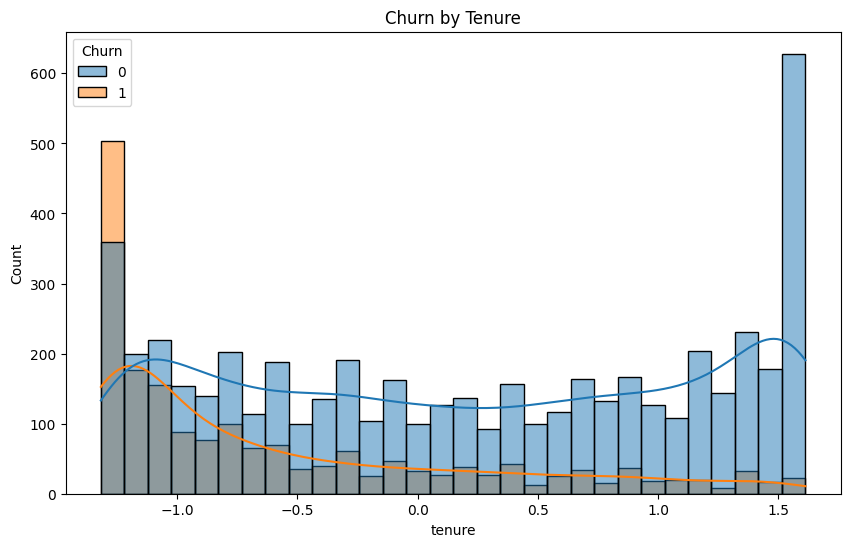

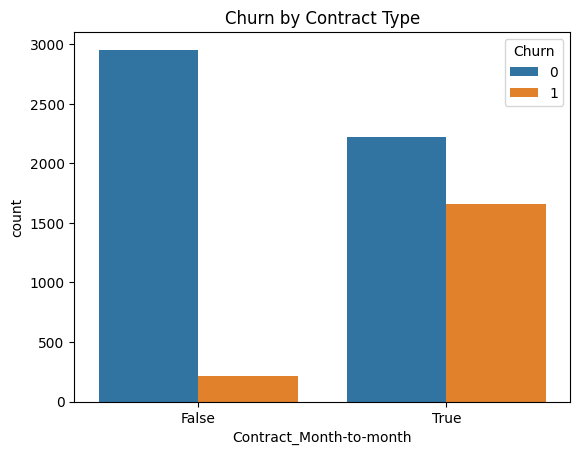

In [5]:
# Churn distribution by tenure
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title("Churn by Tenure")
plt.show()

# Churn distribution by contract type
sns.countplot(data=df, x='Contract_Month-to-month', hue='Churn')
plt.title("Churn by Contract Type")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
X_encoded = X.copy()
categorical_cols = X_encoded.select_dtypes(include=['object']).columns  # Find categorical columns

# Convert categorical columns using Label Encoding (or One-Hot Encoding if necessary)
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X_encoded[col] = label_encoders[col].fit_transform(X_encoded[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("SMOTE applied successfully!")


SMOTE applied successfully!


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Adjust Logistic Regression to prevent convergence issues
log_reg = LogisticRegression(max_iter=500)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}\n")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409

AUC-ROC: 0.7424255341135138

Model: Random Forest
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1035
           1       0.57      0.63      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409

AUC-ROC: 0.7263607946472396



C:\Users\adilm\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [07:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.56      0.63      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409

AUC-ROC: 0.7275853160763647



In [11]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, scoring='roc_auc', cv=3)
grid_rf.fit(X_train_res, y_train_res)
print(f"Best RF AUC-ROC: {roc_auc_score(y_test, grid_rf.best_estimator_.predict(X_test))}")

Best RF AUC-ROC: 0.7268438864346792


In [71]:
print(list(X.columns))  # Check if all features match


['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
